In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_ds = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical')
test_ds = test_datagen.flow_from_directory(
        'data/test',
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [5]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding='same'
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.LeakyReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding='SAME',
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel

In [6]:
print("building the involution model...")

inputs = keras.Input(shape=(150, 150, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
#112,112,3
x, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.LeakyReLU()(x)
#56,56,3
x, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.LeakyReLU()(x)
#28,28,3
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="leaky_relu")(x)
outputs = keras.layers.Dense(2)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# train the model
print("inv model training...")
inv_hist = inv_model.fit(train_ds, epochs=100, validation_data=test_ds)

building the involution model...
compiling the involution model...
inv model training...
Epoch 1/100
42/42 [==============================] - 26s 455ms/step - loss: 0.9604 - accuracy: 0.5112 - val_loss: 0.6930 - val_accuracy: 0.5515
Epoch 2/100
42/42 [==============================] - 18s 422ms/step - loss: 0.7577 - accuracy: 0.5078 - val_loss: 0.6928 - val_accuracy: 0.5439
Epoch 3/100
42/42 [==============================] - 17s 391ms/step - loss: 0.7444 - accuracy: 0.5332 - val_loss: 0.6924 - val_accuracy: 0.5470
Epoch 4/100
42/42 [==============================] - 18s 412ms/step - loss: 0.7431 - accuracy: 0.5658 - val_loss: 0.6921 - val_accuracy: 0.5470
Epoch 5/100
42/42 [==============================] - 17s 393ms/step - loss: 0.7268 - accuracy: 0.5662 - val_loss: 0.6915 - val_accuracy: 0.5561
Epoch 6/100
42/42 [==============================] - 16s 382ms/step - loss: 0.7236 - accuracy: 0.5673 - val_loss: 0.6907 - val_accuracy: 0.5712
Epoch 7/100
42/42 [============================

Epoch 57/100
42/42 [==============================] - 17s 410ms/step - loss: 0.5260 - accuracy: 0.6879 - val_loss: 0.5195 - val_accuracy: 0.6621
Epoch 58/100
42/42 [==============================] - 18s 429ms/step - loss: 0.5336 - accuracy: 0.6932 - val_loss: 0.5169 - val_accuracy: 0.6742
Epoch 59/100
42/42 [==============================] - 17s 407ms/step - loss: 0.5258 - accuracy: 0.6962 - val_loss: 0.5155 - val_accuracy: 0.6682
Epoch 60/100
42/42 [==============================] - 19s 437ms/step - loss: 0.5132 - accuracy: 0.6978 - val_loss: 0.5117 - val_accuracy: 0.6636
Epoch 61/100
42/42 [==============================] - 17s 405ms/step - loss: 0.5112 - accuracy: 0.7072 - val_loss: 0.5147 - val_accuracy: 0.6652
Epoch 62/100
42/42 [==============================] - 17s 410ms/step - loss: 0.5154 - accuracy: 0.7084 - val_loss: 0.5055 - val_accuracy: 0.6682
Epoch 63/100
42/42 [==============================] - 16s 384ms/step - loss: 0.5071 - accuracy: 0.7156 - val_loss: 0.5033 - val_ac

In [7]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inv_1 (Involution)          ((None, 150, 150, 3),     26        
                              (None, 150, 150, 9, 1,             
                             1))                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 150, 150, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 inv_2 (Involution)          ((None, 75, 75, 3),       26        
                              (None, 75, 75, 9, 1, 1)    

In [8]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inv_1 (Involution)          ((None, 150, 150, 3),     26        
                              (None, 150, 150, 9, 1,             
                             1))                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 150, 150, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 inv_2 (Involution)          ((None, 75, 75, 3),       26        
                              (None, 75, 75, 9, 1, 1)    

In [11]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inv_1 (Involution)          ((None, 224, 224, 3),     26        
                              (None, 224, 224, 9, 1,             
                             1))                                 
                                                                 
 softmax_3 (Softmax)         (None, 224, 224, 3)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 3)      0         
 2D)                                                             
                                                                 
 inv_2 (Involution)          ((None, 112, 112, 3),     26        
                              (None, 112, 112, 9, 1,     

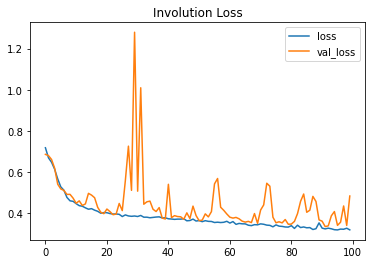

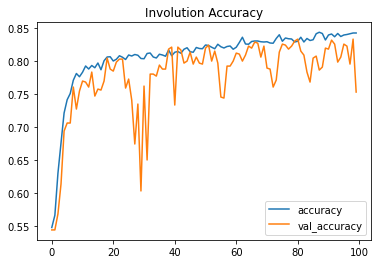

In [20]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

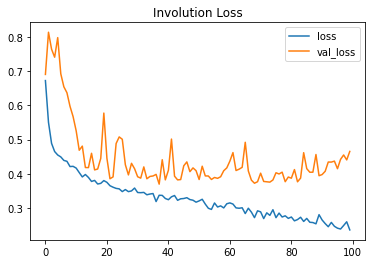

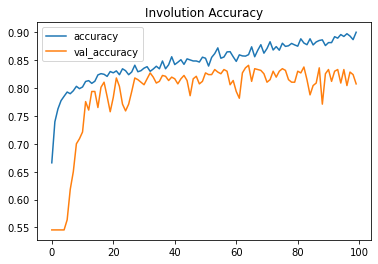

In [8]:
# Leaky Relu 5x5 3 layers 0.001 lr
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

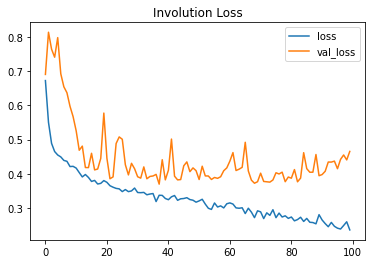

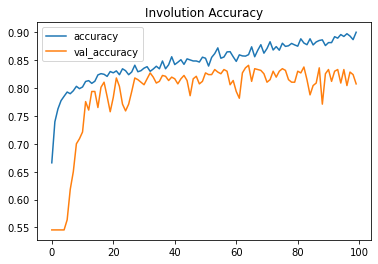

In [9]:
# LEaky Relu 3x3 3 layers
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

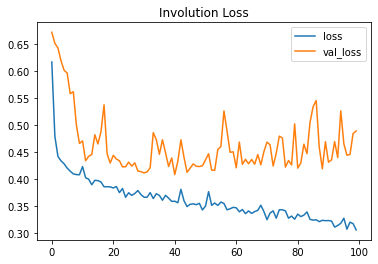

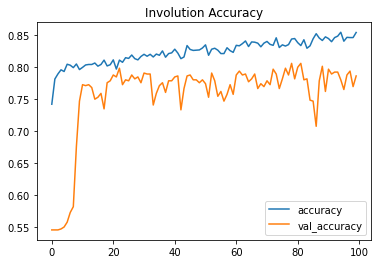

In [33]:
# ELU 5x5 3 layers
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

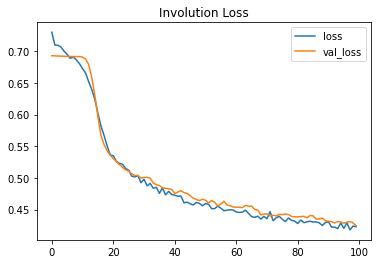

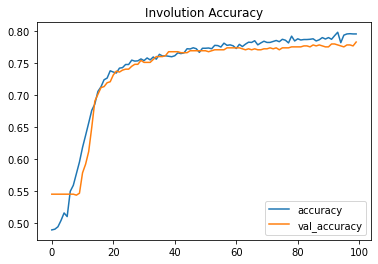

In [7]:
#ELU 4 layers 5x5 dropout 0.5
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

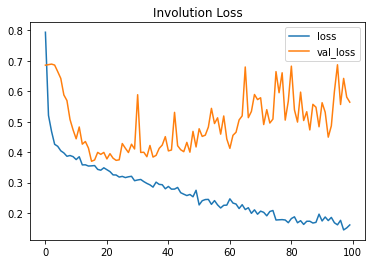

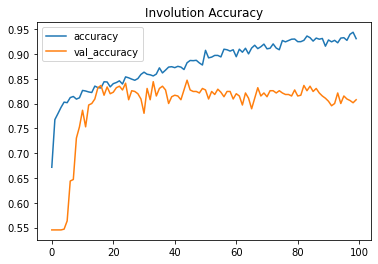

In [116]:
# ELU 5x5 4 layers
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

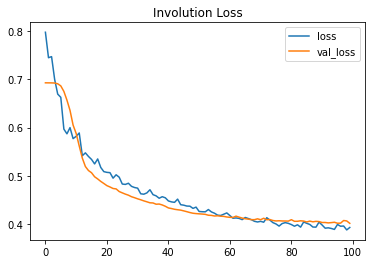

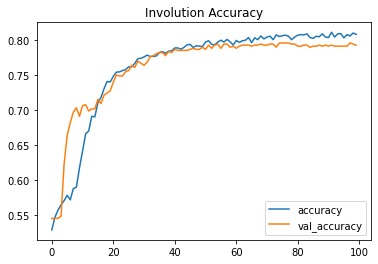

In [130]:
# Leaky ReLU 5x5 4 layers
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

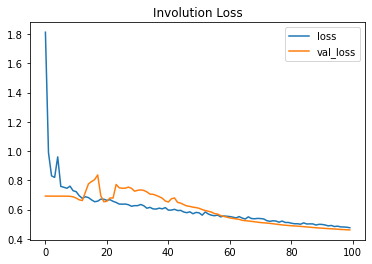

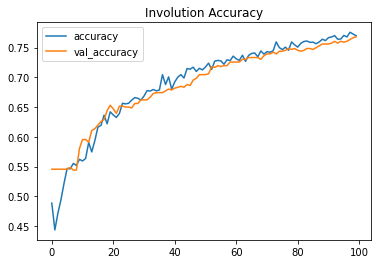

In [17]:
# ELU 3x3 4 layers
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

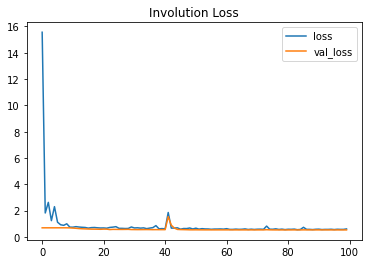

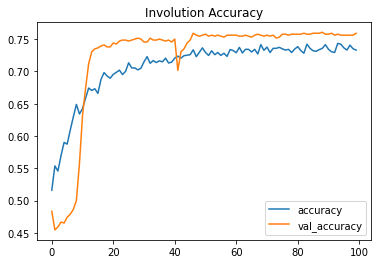

In [33]:
#Leaky RELU 5 layers, 3x3
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

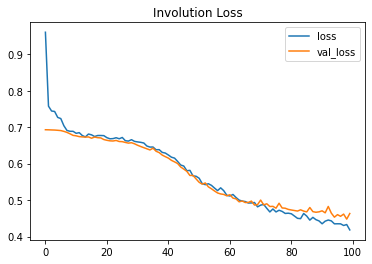

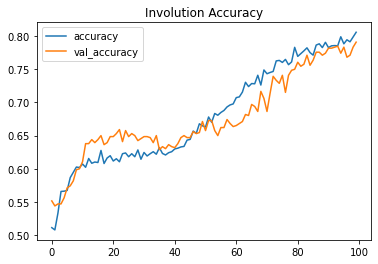

In [7]:
#Leaky RELU 3 layers, 5x5 o.ooo5lr
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

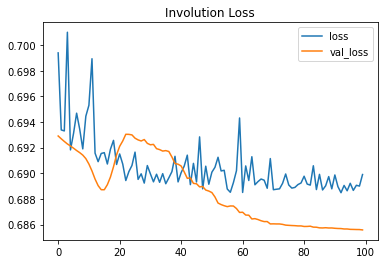

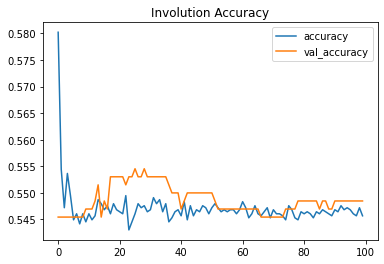

In [22]:
# Leaky ReLU 3x3 4 layers 0.5 dropout
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

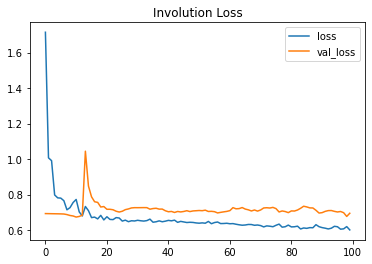

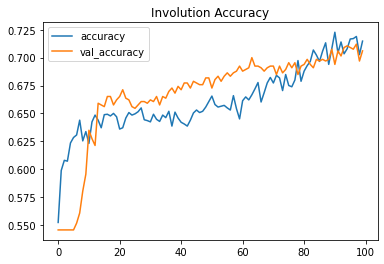

In [29]:
#Leaky RELU 5 layers 5x5 dropout 0.2 0.0008 learning
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

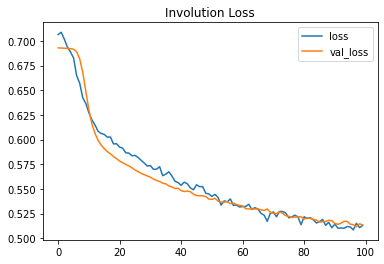

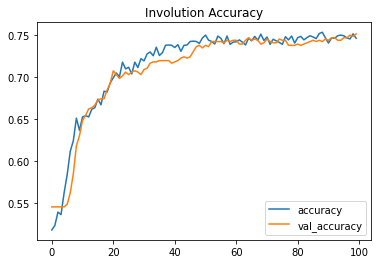

In [141]:
# Leaky relu 3 layers, 5x5 kernel
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [8]:
a = [0]*100
l = [0]*100
for i in range(0,100):
    l[i] = inv_hist.history["val_loss"][i] - inv_hist.history["loss"][i]
    a[i] = inv_hist.history["accuracy"][i] - inv_hist.history["val_accuracy"][i]
sa=0
sl=0
for i in range(0,100):
    sa = sa + a[i]
    sl = sl + l[i]
sa1=0
sa2=0
sl1=0
sl2 = 0
for i in range(0,100):
    sa1 = sa1+inv_hist.history["accuracy"][i]
    sl1 = sl1+inv_hist.history["loss"][i]
    sa2 = sa2+inv_hist.history["val_accuracy"][i]
    sl2 = sl2+inv_hist.history["val_loss"][i]

In [9]:
#Avg Difference in Accuracy
print(sa/100)

0.0032277214527130127


In [10]:
#Avg Difference in Loss
sl/100

-0.0034255948662757873

In [11]:
#Avg Train Accuracy
sa1

68.03943848609924

In [12]:
#Avg Test Accuracy
sa2

67.71666634082794

In [13]:
#Avg Train Loss
sl1/100

0.5723664689064026

In [14]:
#Avg Test Loss
sl2/100

0.5689408740401268

In [15]:
df = pd.DataFrame(inv_hist.history["val_accuracy"])

In [16]:
df.max()

0    0.790909
dtype: float64

In [ ]:
class Involution(nn.Module):
    def __init__(self,in_channels, out_channels=3,kernel_size, stride, padding, groups=1):
        super(Involution, self).__init__()
        reduction_ratio=4
        channels_per_group=16
        self.channels=channels
        self.channels_per_group = channels_per_group
        self.reduction_ratio = reduction_ratio
        self.groups = channels // channels_per_group
        self.kernel_size = kernel_size
        self.weights0 = nn.Conv2d(self.channels, self.channels // self.reduction_ratio,1)
        self.BN = nn.BatchNorm2d(self.channels // self.reduction_ratio)
        self.relu = nn.ReLU(True)
        self.weights1 = nn.Conv2d(self.channels // self.reduction_ratio,self.groups * self.kernel_size**2,1)
        self.kernel_generator = nn.Sequential(self.weights0,
                                              self.BN,
                                              self.relu,
                                              self.weights1)
        self.patch_maker = nn.Unfold(self.kernel_size,1,(self.kernel_size -1)//2,1)
    def forward(self,x):
        b,c,h,w = x.shape
        # Generate Kernels using the input image
        kernel_weights = self.kernel_generator(x)
        # print('Kernel Weights ',kernel_weights.shape)
        # ReShape the kernels into appropriate shape
        kernels = kernel_weights.view(b,self.groups,1,self.kernel_size**2,h,w)#.unsqueeze(2)
        # print('Kernels ',kernels.shape)
        patches = self.patch_maker(x).view(b, self.groups,self.channels_per_group,self.kernel_size**2,h,w)
        # print('Patches ',patches.shape)
        return (patches*kernels).sum(dim=3).view(b,self.channels,h,w)